<div align="center" style="background: linear-gradient(to right, #0b0f1a, #13293d, #274060); padding:28px; border-radius:18px">
  <h1 style="color:#fff; margin:0">Tennis ATP ETL Pipeline + Data Quality Monitoring</h1>
  <p style="color:#cbd5e1; margin:10px 0 0 0; font-size:16px">
    Production-minded pipeline: ingest → validate → model → partition → API-ready outputs
  </p>
</div>


This notebook demonstrates the exact capabilities listed in the job spec:
- **Build and maintain robust ETL pipelines** -Typed ingest, schema rules, Bronze→Silver→Gold layers
- **Manage central database / optimise data architecture** - Normalized dim/fact model + Parquet partitions
- **Monitor data quality for accuracy and completeness** - Automated DQ checks, severity scoring, daily reports
- **Develop and deploy scalable APIs** - JSON payload contracts ready for Flask/FastAPI

---
## 1. Setup & Configuration

In [1]:
import os
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Any, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Pipeline configuration
CONFIG = {
    'source_file': 'atp_tennis.csv',
    'output_dir': 'pipeline_output',
}

Path(CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)
print(f"Pipeline initialized at {datetime.now().isoformat()}")

Pipeline initialized at 2026-02-03T20:13:32.785073


---
## 2. EXTRACT: Bronze Layer (Raw Ingestion)

In [2]:
# Load raw data
RAW = pd.read_csv(CONFIG['source_file'], low_memory=False)
print(f"Loaded {len(RAW):,} rows, {len(RAW.columns)} columns")
print(f"Columns: {RAW.columns.tolist()}")
RAW.head(3)

Loaded 66,910 rows, 17 columns
Columns: ['Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Player_1', 'Player_2', 'Winner', 'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2', 'Score']


,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score
0,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,Dosedel S.,63,77,-1,-1,-1.0,-1,6-4 6-2
1,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Clement A.,Enqvist T.,Enqvist T.,56,5,-1,-1,-1.0,-1,3-6 3-6
2,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,Escude N.,40,655,-1,-1,-1.0,-1,6-7 7-5 6-3


---
## 3. TRANSFORM: Bronze → Silver (Typed & Cleaned)

In [3]:
df = RAW.copy()
df.columns = [c.strip() for c in df.columns]

# Type coercion
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

for c in ["Best of", "Rank_1", "Rank_2", "Pts_1", "Pts_2", "Odd_1", "Odd_2"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

for c in ["Tournament", "Series", "Court", "Surface", "Round", "Player_1", "Player_2", "Winner", "Score"]:
    if c in df.columns:
        df[c] = df[c].astype("string").str.strip()

# Derived partition columns
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month

print(f"Silver layer: {len(df):,} rows")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
df.head(3)

Silver layer: 66,910 rows
Date range: 2000-01-03 00:00:00 to 2026-02-01 00:00:00


,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score,year,month
0,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,Dosedel S.,63,77,-1,-1,-1.0,-1.0,6-4 6-2,2000,1
1,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Clement A.,Enqvist T.,Enqvist T.,56,5,-1,-1,-1.0,-1.0,3-6 3-6,2000,1
2,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,Escude N.,40,655,-1,-1,-1.0,-1.0,6-7 7-5 6-3,2000,1


---
## 4. DATA QUALITY: Schema Validation

Production pipelines need declared schemas with validation rules.

In [4]:
@dataclass
class ColumnRule:
    name: str
    required: bool = True
    dtype: Optional[str] = None
    min_value: Optional[float] = None
    max_value: Optional[float] = None
    allowed_values: Optional[List[str]] = None

SCHEMA_RULES = [
    ColumnRule("Date", required=True),
    ColumnRule("Tournament", required=True),
    ColumnRule("Surface", required=False, allowed_values=["Hard", "Clay", "Grass", "Carpet"]),
    ColumnRule("Player_1", required=True),
    ColumnRule("Player_2", required=True),
    ColumnRule("Winner", required=True),
    ColumnRule("Odd_1", required=False, min_value=1.01),
    ColumnRule("Odd_2", required=False, min_value=1.01),
    ColumnRule("Rank_1", required=False, min_value=1),
    ColumnRule("Rank_2", required=False, min_value=1),
]

def run_schema_checks(df: pd.DataFrame, rules: List[ColumnRule]) -> Dict[str, Any]:
    """Validate dataframe against schema rules."""
    results = {"missing_columns": [], "rule_violations": []}
    
    for r in rules:
        if r.name not in df.columns:
            if r.required:
                results["missing_columns"].append(r.name)
            continue
        
        s = df[r.name]
        
        # Required null check
        if r.required:
            null_rate = float(s.isna().mean())
            if null_rate > 0:
                results["rule_violations"].append({
                    "column": r.name, "rule": "required_not_null", 
                    "null_rate": round(null_rate * 100, 2)
                })
        
        # Range checks
        if r.min_value is not None:
            bad = s.dropna() < r.min_value
            if bad.any():
                results["rule_violations"].append({
                    "column": r.name, "rule": f">= {r.min_value}",
                    "bad_count": int(bad.sum())
                })
        
        # Allowed values
        if r.allowed_values is not None:
            bad = ~s.dropna().isin(r.allowed_values)
            if bad.any():
                results["rule_violations"].append({
                    "column": r.name, "rule": f"in {r.allowed_values}",
                    "bad_count": int(bad.sum()),
                    "examples": s.dropna()[bad].head(5).tolist()
                })
    
    return results

schema_results = run_schema_checks(df, SCHEMA_RULES)
print("SCHEMA VALIDATION RESULTS")
print("-" * 40)
print(json.dumps(schema_results, indent=2))

SCHEMA VALIDATION RESULTS
----------------------------------------
{
  "missing_columns": [],
  "rule_violations": [
    {
      "column": "Odd_1",
      "rule": ">= 1.01",
      "bad_count": 3913
    },
    {
      "column": "Odd_2",
      "rule": ">= 1.01",
      "bad_count": 3896
    },
    {
      "column": "Rank_1",
      "rule": ">= 1",
      "bad_count": 14
    },
    {
      "column": "Rank_2",
      "rule": ">= 1",
      "bad_count": 12
    }
  ]
}


---
## 5. DATA QUALITY: Comprehensive DQ Report

This is what you'd run daily and send to Slack/Grafana.

In [5]:
def generate_dq_report(df: pd.DataFrame) -> Dict[str, Any]:
    """Generate comprehensive data quality report."""
    report = {
        "generated_at": datetime.now().isoformat(),
        "total_rows": len(df),
        "date_range": {
            "min": str(df["Date"].min().date()) if not df["Date"].isna().all() else None,
            "max": str(df["Date"].max().date()) if not df["Date"].isna().all() else None
        },
        "completeness": {},
        "validity": {},
        "issues": []
    }
    
    # Completeness - null rates for key columns
    key_cols = ["Date", "Tournament", "Player_1", "Player_2", "Winner", "Score"]
    for col in key_cols:
        if col in df.columns:
            null_pct = round(df[col].isna().mean() * 100, 2)
            report["completeness"][col] = {"null_pct": null_pct, "complete_pct": 100 - null_pct}
            if null_pct > 5:
                report["issues"].append({"severity": "HIGH", "field": col, 
                                          "message": f"{col} has {null_pct}% missing"})
    
    # Validity checks
    report["validity"]["duplicate_rows"] = int(df.duplicated().sum())
    
    # Bad odds (should be > 1, or -1 for missing)
    if "Odd_1" in df.columns and "Odd_2" in df.columns:
        bad_odds = ((df["Odd_1"] <= 1) & (df["Odd_1"] != -1)) | ((df["Odd_2"] <= 1) & (df["Odd_2"] != -1))
        report["validity"]["invalid_odds_count"] = int(bad_odds.sum())
    
    # Bad ranks (should be > 0, or -1 for missing)
    if "Rank_1" in df.columns and "Rank_2" in df.columns:
        bad_ranks = ((df["Rank_1"] <= 0) & (df["Rank_1"] != -1)) | ((df["Rank_2"] <= 0) & (df["Rank_2"] != -1))
        report["validity"]["invalid_ranks_count"] = int(bad_ranks.sum())
    
    # Winner consistency (must be Player_1 or Player_2)
    winner_mismatch = (df["Winner"] != df["Player_1"]) & (df["Winner"] != df["Player_2"])
    report["validity"]["winner_mismatch_count"] = int(winner_mismatch.sum())
    if winner_mismatch.sum() > 0:
        report["issues"].append({"severity": "HIGH", "field": "Winner",
                                  "message": f"{winner_mismatch.sum()} rows where Winner != Player_1 or Player_2"})
    
    # Calculate DQ score
    high_issues = len([i for i in report["issues"] if i["severity"] == "HIGH"])
    report["dq_score"] = round(max(0, 100 - (high_issues * 25)), 1)
    
    return report

dq_report = generate_dq_report(df)

print("=" * 50)
print(f"DATA QUALITY SCORE: {dq_report['dq_score']}%")
print("=" * 50)
print(f"\nDate Range: {dq_report['date_range']['min']} to {dq_report['date_range']['max']}")
print(f"Total Rows: {dq_report['total_rows']:,}")
print(f"\nIssues: {len(dq_report['issues'])}")
for issue in dq_report['issues']:
    print(f"  [{issue['severity']}] {issue['message']}")

DATA QUALITY SCORE: 100%

Date Range: 2000-01-03 to 2026-02-01
Total Rows: 66,910

Issues: 0


In [6]:
# Save DQ report as JSON artifact
dq_path = f"{CONFIG['output_dir']}/dq_report.json"
with open(dq_path, "w") as f:
    json.dump(dq_report, f, indent=2)
print(f"DQ report saved to: {dq_path}")

DQ report saved to: pipeline_output/dq_report.json


---
## 6. TRANSFORM: Score Parsing (Feature Engineering)

In [7]:
score_re = re.compile(r"(?P<a>\d+)-(?P<b>\d+)(?:\((?P<tb>\d+)\))?")

def parse_score(score: Optional[str]) -> Optional[Dict[str, Any]]:
    """Parse tennis score into structured features."""
    if score is None or pd.isna(score):
        return None
    
    s = str(score).strip()
    parts = re.split(r"\s+", s)
    sets = []
    
    for p in parts:
        m = score_re.search(p)
        if m:
            a, b = int(m.group("a")), int(m.group("b"))
            tb = int(m.group("tb")) if m.group("tb") else None
            sets.append((a, b, tb))
    
    if not sets:
        return None
    
    sets1 = sum(1 for a, b, _ in sets if a > b)
    sets2 = sum(1 for a, b, _ in sets if b > a)
    games1 = sum(a for a, _, _ in sets)
    games2 = sum(b for _, b, _ in sets)
    
    return {
        "n_sets": len(sets),
        "sets1": sets1, "sets2": sets2,
        "games1": games1, "games2": games2,
        "tiebreak_sets": sum(1 for _, _, tb in sets if tb is not None),
        "straight_sets": sets1 == len(sets) or sets2 == len(sets)
    }

# Parse all scores
parsed = df["Score"].apply(parse_score)
score_feats = pd.json_normalize(parsed)
silver = pd.concat([df, score_feats], axis=1)

parse_fail_rate = silver["n_sets"].isna().mean() * 100
print(f"Score parse failure rate: {parse_fail_rate:.2f}%")
print(f"\nSample parsed scores:")
silver[["Score", "n_sets", "sets1", "sets2", "games1", "games2", "straight_sets"]].head(5)

Score parse failure rate: 0.00%

Sample parsed scores:


,Score,n_sets,sets1,sets2,games1,games2,straight_sets
0,6-4 6-2,2,2,0,12,6,True
1,3-6 3-6,2,0,2,6,12,True
2,6-7 7-5 6-3,3,2,1,19,15,False
3,1-6 4-6,2,0,2,5,12,True
4,7-6 5-7 6-4,3,2,1,18,17,False


---
## 7. MODEL: Silver → Gold (Dimensional Tables)

Creating warehouse-friendly star schema:
- **dim_players** - Player dimension
- **dim_tournaments** - Tournament dimension
- **fact_matches** - Match facts

In [8]:
# dim_players
players = pd.concat([silver["Player_1"], silver["Player_2"], silver["Winner"]]).dropna().unique()
dim_players = pd.DataFrame({"player_name": sorted(players)})
dim_players["player_id"] = range(1, len(dim_players) + 1)
player_to_id = dict(zip(dim_players["player_name"], dim_players["player_id"]))

# dim_tournaments
dim_tournaments = silver[["Tournament", "Series", "Surface", "Court"]].drop_duplicates().reset_index(drop=True)
dim_tournaments["tournament_id"] = range(1, len(dim_tournaments) + 1)

# fact_matches
fact = silver.merge(dim_tournaments, on=["Tournament", "Series", "Surface", "Court"], how="left")
fact["p1_id"] = fact["Player_1"].map(player_to_id)
fact["p2_id"] = fact["Player_2"].map(player_to_id)
fact["winner_id"] = fact["Winner"].map(player_to_id)

fact_matches = fact[[
    "Date", "year", "month", "tournament_id", "Round", "Best of",
    "p1_id", "p2_id", "winner_id",
    "Rank_1", "Rank_2", "Pts_1", "Pts_2", "Odd_1", "Odd_2",
    "Score", "n_sets", "sets1", "sets2", "games1", "games2", "straight_sets"
]].copy()

print(f"dim_players: {len(dim_players):,} rows")
print(f"dim_tournaments: {len(dim_tournaments):,} rows")
print(f"fact_matches: {len(fact_matches):,} rows")

dim_players: 1,713 rows
dim_tournaments: 340 rows
fact_matches: 66,910 rows


In [9]:
dim_players.head(10)

,player_name,player_id
0,Abdulla M.,1
1,Abel M.,2
2,Acasuso J.,3
3,Adaktusson J.,4
4,Added D.,5
5,Agaev E.,6
6,Agamenone F.,7
7,Agassi A.,8
8,Agenor R.,9
9,Ager J.,10


---
## 8. LOAD: Partitioned Parquet Outputs

Mimicking S3 warehouse layout: `s3://bucket/fact_matches/year=2024/month=06/`

In [10]:
def write_partitioned_parquet(df: pd.DataFrame, base: str, partition_cols: List[str]):
    """Write partitioned parquet files."""
    base_path = Path(base)
    base_path.mkdir(parents=True, exist_ok=True)
    
    for keys, chunk in df.groupby(partition_cols, dropna=False):
        if not isinstance(keys, tuple):
            keys = (keys,)
        subdir = base_path
        for col, val in zip(partition_cols, keys):
            subdir = subdir / f"{col}={val}"
        subdir.mkdir(parents=True, exist_ok=True)
        chunk.drop(columns=partition_cols).to_parquet(subdir / "data.parquet", index=False)

# Write outputs
OUT_DIR = CONFIG['output_dir']
write_partitioned_parquet(fact_matches.dropna(subset=["year", "month"]), f"{OUT_DIR}/fact_matches", ["year", "month"])
dim_players.to_parquet(f"{OUT_DIR}/dim_players.parquet", index=False)
dim_tournaments.to_parquet(f"{OUT_DIR}/dim_tournaments.parquet", index=False)

print(f"Parquet files written to: {OUT_DIR}/")
print(f"  - dim_players.parquet")
print(f"  - dim_tournaments.parquet")
print(f"  - fact_matches/ (partitioned by year/month)")

Parquet files written to: pipeline_output/
  - dim_players.parquet
  - dim_tournaments.parquet
  - fact_matches/ (partitioned by year/month)


---
## 9. API PAYLOADS: Ready for Flask/FastAPI

Stable inputs → stable outputs. These contracts power broadcast graphics.

In [11]:
# Build enriched fact table for API queries
fact_plus = fact_matches.merge(
    dim_players.rename(columns={"player_name": "p1_name", "player_id": "p1_player_id"}),
    left_on="p1_id", right_on="p1_player_id", how="left"
).merge(
    dim_players.rename(columns={"player_name": "p2_name", "player_id": "p2_player_id"}),
    left_on="p2_id", right_on="p2_player_id", how="left"
).merge(
    dim_players.rename(columns={"player_name": "winner_name", "player_id": "w_player_id"}),
    left_on="winner_id", right_on="w_player_id", how="left"
).merge(
    dim_tournaments[["tournament_id", "Tournament", "Surface", "Series"]],
    on="tournament_id", how="left"
)

In [12]:
def player_career_stats(player_name: str) -> Dict[str, Any]:
    """GET /api/players/{name}/stats"""
    
    # Matches as player 1
    p1_matches = fact_plus[fact_plus["p1_name"] == player_name].copy()
    p1_matches["is_win"] = p1_matches["winner_id"] == p1_matches["p1_id"]
    
    # Matches as player 2
    p2_matches = fact_plus[fact_plus["p2_name"] == player_name].copy()
    p2_matches["is_win"] = p2_matches["winner_id"] == p2_matches["p2_id"]
    
    all_matches = pd.concat([p1_matches, p2_matches])
    
    if len(all_matches) == 0:
        return {"error": "Player not found"}
    
    wins = all_matches["is_win"].sum()
    losses = len(all_matches) - wins
    
    # Surface breakdown
    surface_stats = {}
    for surface in ["Hard", "Clay", "Grass"]:
        s_matches = all_matches[all_matches["Surface"] == surface]
        if len(s_matches) > 0:
            s_wins = s_matches["is_win"].sum()
            surface_stats[surface.lower()] = {
                "matches": len(s_matches),
                "wins": int(s_wins),
                "win_rate": round(s_wins / len(s_matches) * 100, 1)
            }
    
    return {
        "player": player_name,
        "career": {
            "total_matches": len(all_matches),
            "wins": int(wins),
            "losses": int(losses),
            "win_rate": round(wins / len(all_matches) * 100, 1)
        },
        "by_surface": surface_stats,
        "generated_at": datetime.now().isoformat()
    }

# Example
payload = player_career_stats("Federer R.")
print("GET /api/players/Federer R./stats")
print("-" * 40)
print(json.dumps(payload, indent=2))

GET /api/players/Federer R./stats
----------------------------------------
{
  "player": "Federer R.",
  "career": {
    "total_matches": 1402,
    "wins": 1157,
    "losses": 245,
    "win_rate": 82.5
  },
  "by_surface": {
    "hard": {
      "matches": 862,
      "wins": 719,
      "win_rate": 83.4
    },
    "clay": {
      "matches": 273,
      "wins": 210,
      "win_rate": 76.9
    },
    "grass": {
      "matches": 208,
      "wins": 182,
      "win_rate": 87.5
    }
  },
  "generated_at": "2026-02-03T20:13:42.933959"
}


In [13]:
def head_to_head(player1: str, player2: str) -> Dict[str, Any]:
    """GET /api/h2h/{player1}/{player2}"""
    
    h2h = fact_plus[
        ((fact_plus["p1_name"] == player1) & (fact_plus["p2_name"] == player2)) |
        ((fact_plus["p1_name"] == player2) & (fact_plus["p2_name"] == player1))
    ].sort_values("Date", ascending=False)
    
    p1_wins = len(h2h[h2h["winner_name"] == player1])
    p2_wins = len(h2h[h2h["winner_name"] == player2])
    
    recent = h2h.head(5)[["Date", "Tournament", "Round", "Surface", "winner_name", "Score"]].copy()
    recent["Date"] = recent["Date"].dt.strftime("%Y-%m-%d")
    
    return {
        "player_1": player1,
        "player_2": player2,
        "head_to_head": {"p1_wins": p1_wins, "p2_wins": p2_wins, "total": len(h2h)},
        "recent_matches": recent.to_dict(orient="records"),
        "generated_at": datetime.now().isoformat()
    }

# Example: Federer vs Nadal
h2h_payload = head_to_head("Federer R.", "Nadal R.")
print("GET /api/h2h/Federer R./Nadal R.")
print("-" * 40)
print(json.dumps(h2h_payload, indent=2))

GET /api/h2h/Federer R./Nadal R.
----------------------------------------
{
  "player_1": "Federer R.",
  "player_2": "Nadal R.",
  "head_to_head": {
    "p1_wins": 16,
    "p2_wins": 24,
    "total": 40
  },
  "recent_matches": [
    {
      "Date": "2019-07-12",
      "Tournament": "Wimbledon",
      "Round": "Semifinals",
      "Surface": "Grass",
      "winner_name": "Federer R.",
      "Score": "6-7 6-1 3-6 4-6"
    },
    {
      "Date": "2019-06-07",
      "Tournament": "French Open",
      "Round": "Semifinals",
      "Surface": "Clay",
      "winner_name": "Nadal R.",
      "Score": "6-3 6-4 6-2"
    },
    {
      "Date": "2017-10-15",
      "Tournament": "Shanghai Masters",
      "Round": "The Final",
      "Surface": "Hard",
      "winner_name": "Federer R.",
      "Score": "6-4 6-3"
    },
    {
      "Date": "2017-03-16",
      "Tournament": "BNP Paribas Open",
      "Round": "4th Round",
      "Surface": "Hard",
      "winner_name": "Federer R.",
      "Score": "2-6 3-6"

In [14]:
# Save API payloads
api_dir = f"{OUT_DIR}/api_payloads"
Path(api_dir).mkdir(exist_ok=True)

with open(f"{api_dir}/player_federer.json", "w") as f:
    json.dump(player_career_stats("Federer R."), f, indent=2)

with open(f"{api_dir}/h2h_federer_nadal.json", "w") as f:
    json.dump(head_to_head("Federer R.", "Nadal R."), f, indent=2)

with open(f"{api_dir}/h2h_djokovic_nadal.json", "w") as f:
    json.dump(head_to_head("Djokovic N.", "Nadal R."), f, indent=2)

print(f"API payloads saved to: {api_dir}/")

API payloads saved to: pipeline_output/api_payloads/


---
## 10. VISUALIZATION: DQ Dashboard

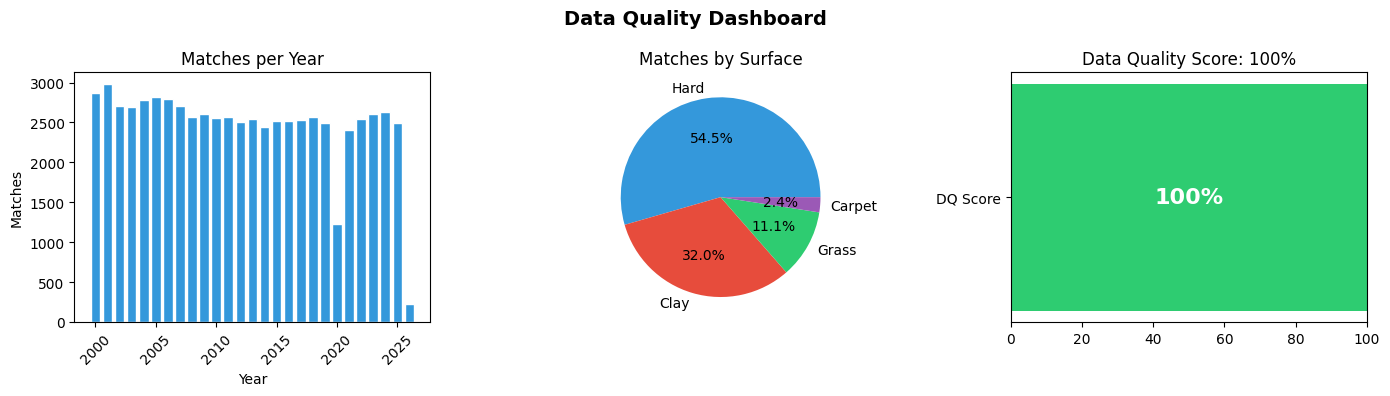

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Data Quality Dashboard', fontsize=14, fontweight='bold')

# 1. Matches per year
yearly = silver.groupby("year").size()
axes[0].bar(yearly.index, yearly.values, color='#3498db', edgecolor='white')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Matches')
axes[0].set_title('Matches per Year')
axes[0].tick_params(axis='x', rotation=45)

# 2. Surface distribution
surface_counts = silver['Surface'].value_counts()
axes[1].pie(surface_counts.values, labels=surface_counts.index, autopct='%1.1f%%',
            colors=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'])
axes[1].set_title('Matches by Surface')

# 3. DQ Score
dq_score = dq_report['dq_score']
color = '#2ecc71' if dq_score >= 80 else '#f39c12' if dq_score >= 60 else '#e74c3c'
axes[2].barh(['DQ Score'], [dq_score], color=color, height=0.4)
axes[2].barh(['DQ Score'], [100 - dq_score], left=[dq_score], color='#ecf0f1', height=0.4)
axes[2].set_xlim(0, 100)
axes[2].set_title(f'Data Quality Score: {dq_score}%')
axes[2].text(dq_score/2, 0, f'{dq_score}%', ha='center', va='center', fontsize=16, fontweight='bold', color='white')

plt.tight_layout()
plt.savefig(f"{CONFIG['output_dir']}/dq_dashboard.png", dpi=150, bbox_inches='tight')
plt.show()

---
## 11. Pipeline Summary

In [ ]:
# Pipeline metadata
pipeline_meta = {
    "pipeline": "Tennis ATP ETL",
    "version": "1.0.0",
    "run_at": datetime.now().isoformat(),
    "source": CONFIG['source_file'],
    "records_processed": len(silver),
    "dq_score": dq_report['dq_score'],
    "outputs": {
        "dim_players": len(dim_players),
        "dim_tournaments": len(dim_tournaments),
        "fact_matches": len(fact_matches),
        "partitions": "year/month"
    }
}

with open(f"{CONFIG['output_dir']}/pipeline_metadata.json", "w") as f:
    json.dump(pipeline_meta, f, indent=2)

print("=" * 60)
print("PIPELINE RUN COMPLETE")
print("=" * 60)
print(f"\nRecords: {pipeline_meta['records_processed']:,}")
print(f"DQ Score: {pipeline_meta['dq_score']}%")
print(f"\nOutputs in: {CONFIG['output_dir']}/")
print(f"  - dim_players.parquet ({len(dim_players):,} players)")
print(f"  - dim_tournaments.parquet ({len(dim_tournaments):,} tournaments)")
print(f"  - fact_matches/ (partitioned)")
print(f"  - api_payloads/")
print(f"  - dq_report.json")
print(f"  - dq_dashboard.png")

PIPELINE RUN COMPLETE

Records: 66,910
DQ Score: 100%

Outputs in: pipeline_output/
  - dim_players.parquet (1,713 players)
  - dim_tournaments.parquet (340 tournaments)
  - fact_matches/ (partitioned)
  - api_payloads/
  - dq_report.json
  - dq_dashboard.png
